## Regression of UK Exports Over Time

Data downloaded from the Office for National Statistics:
https://www.ons.gov.uk/economy/nationalaccounts/balanceofpayments/timeseries/lqad/mret

In [5]:
import pandas as pd
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [6]:
## READ DATA

df = pd.read_csv('series-230425 (1).csv') # Read ONS trade data
df = df.drop(list(range(0,147))).reset_index(drop=True) # Get rid of header & additional info and reset index.
df.rename(columns={df.columns[0]: 'date', df.columns[1]: 'exports'}, inplace=True) # Re-name columns for simplicity
df['exports'] = pd.to_numeric(df['exports'], errors='coerce')

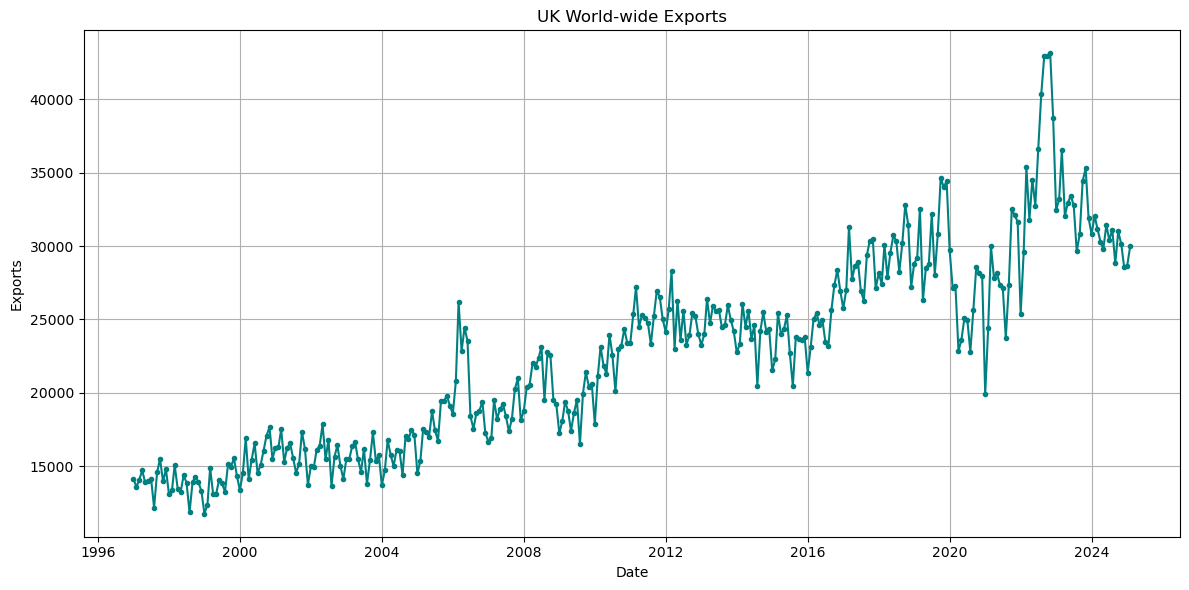

In [17]:
## PLOT EXPORTS

df['date'] = pd.to_datetime(df['date'], format='%Y %b') # Make 'date' column datetime type

plt.figure(figsize=(12, 6)) # Create plot
plt.plot(df['date'], df['exports'], marker='o', markersize=3,linestyle='-', color='teal')
plt.title('UK World-wide Exports')
plt.xlabel('Date')
plt.ylabel('Exports')
plt.grid(True)
plt.tight_layout()
plt.show()  

In [7]:
# Split data for training & testing
# Trained on historical data; Tested on past year (Mar 2024 - Feb 2025)

train_size = 326
test_size = 12

Y_train = df.iloc[:train_size, 1]  # First 326 points
Y_test = df.iloc[-test_size:, 1]  # Last 12 points
X_train = df.iloc[:train_size, 0]  # First 326 points
X_test = df.iloc[-test_size:, 0]  # Last 12 points

## S-ARIMA Approach:

Seasonal Auto-Regressive Integrated Moving Average (S-ARIMA) models are a common modelling technique for time series data. The model allows us to express future values in terms of past values as well as modelling trend, stochasticity and seasonality. 

As our exports data is monthly, we can most likely assume that our order of seasonality should be every 12 months.

The trend of our data also seems close to linear (a polynomial of order 1). This means that we can choose integration of order 1 for our model.

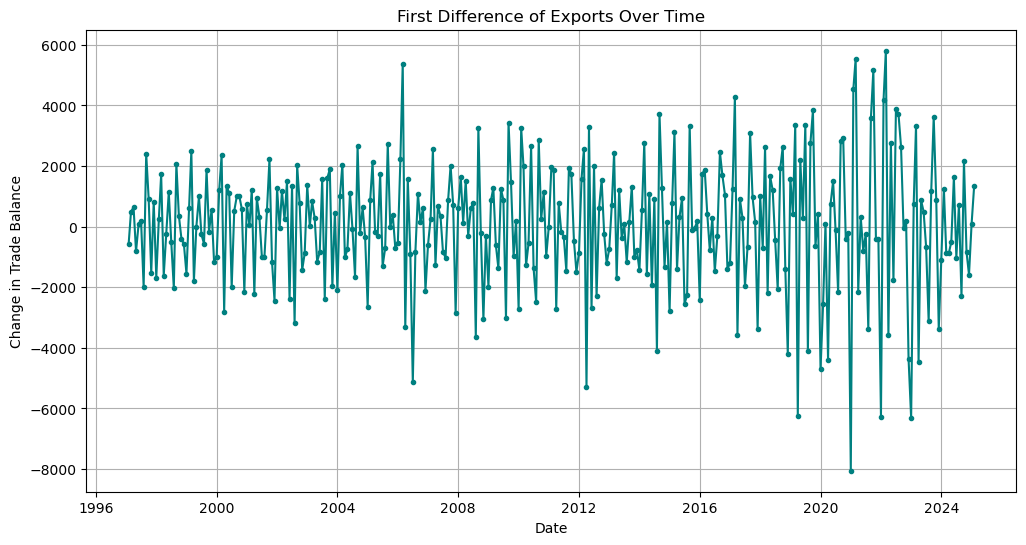

ADF Statistic: -5.74977981258532
p-value: 6.003841841406085e-07


In [19]:
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['exports'].diff(), marker='o', markersize =3, linestyle='-', color='teal')
plt.xlabel("Date")
plt.ylabel("Change in Trade Balance")
plt.title("First Difference of Exports Over Time")
plt.grid(True)
plt.show()

from statsmodels.tsa.stattools import adfuller

# Make sure the tradebalance column is numeric
df['exports'] = pd.to_numeric(df['exports'], errors='coerce')

# Take first difference & drop missing values (optional but useful before ADF)
diff_series = df['exports'].diff().dropna()

# Perform Augmented Dickey-Fuller test
result = adfuller(diff_series)

# Print the test results
print("ADF Statistic:", result[0])
print("p-value:", result[1])


After first-differencing, exports seem more stationary.

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

We can search for the best model form by checking many models and comparing their AIC.

In [22]:
# Automatic procedure: Checks each model form and selects model with lowest AIC.

import pmdarima as pm

automodel = pm.auto_arima(Y_train,
                      seasonal=True,
                      m=12,
                      d=1,
                      D=1,
                      max_P=2, max_Q=2,
                      trace=True,
                      max_iter=500,
                      disp=False)
print(automodel.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=5494.735, Time=1.67 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5598.851, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5561.978, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5495.604, Time=0.34 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=5497.969, Time=1.78 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=inf, Time=0.94 sec
 ARIMA(2,1,2)(2,1,1)[12]             : AIC=inf, Time=3.66 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=inf, Time=3.86 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(2,1,2)(0,1,2)[12]             : AIC=inf, Time=2.12 sec
 ARIMA(2,1,2)(2,1,0)[12]             : AIC=5523.443, Time=1.78 sec
 ARIMA(2,1,2)(2,1,2)[12]             : AIC=5501.485, Time=2.97 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=inf, Time=1.11 sec
 ARIMA(3,1,2)(1,1,1)[12]             : AIC=inf, Time=1

The 'best' model was SARIMAX(0,1,1)x(2,1,2)[12]. It is not intuitive why we do not have any AR component and upon looking at the output, the model with AR part included was disqualified because the MLE optimisation did not converge. We can try that model again and see if it does any better:

In [26]:
model_sarima = SARIMAX(
    Y_train,
    order=(1,1,1),
    seasonal_order=(2,1,2,12)
).fit(maxiter=500, disp=False)
print(model_sarima.aic)

print(model_sarima.mle_retvals) # The MLEs converged
model_sarima.summary()

5455.157891421999
{'fopt': 8.345334189297544, 'gopt': array([-2.44462228e-06,  7.46069874e-09,  2.91771940e-05,  1.33280054e-05,
       -6.78177514e-06,  1.03707265e-05,  3.58824082e-08]), 'fcalls': 496, 'warnflag': 0, 'converged': True, 'iterations': 53}


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                 exports   No. Observations:                  326
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood               -2720.579
Date:                                 Tue, 29 Apr 2025   AIC                           5455.158
Time:                                         11:12:01   BIC                           5481.381
Sample:                                              0   HQIC                          5465.637
                                                 - 326                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8378      0.025     33.971      0.000       0.789       0.886
ma.L1         -1.0000      0.055    -18.153      0.000      -1.108      -0.892
ar.S.L12       0.9158      0.122      7.501      0.000       0.676       1.155
ar.S.L24      -0.4633      0.051     -9.036      0.000      -0.564      -0.363
ma.S.L12      -1.5716      0.127    -12.366      0.000      -1.821      -1.323
ma.S.L24       0.7077      0.118      6.010      0.000       0.477       0.939
sigma2      1.912e+06   2.88e-08   6.64e+13      0.000    1.91e+06    1.91e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.68   Jarque-Bera (JB):               112.52
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               2.95   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.17e+29. Standard errors may be unstable.
"""

The model with the AR(1) component converged this time and the AIC score is 10 better which is fairly substantial.

This has a few problems as residuals seem serially correlated. Also, the Jarque-Bera test for normality has a small p-value indicating normal errors are a poor assumption here.

(4807.553572958769, 0.0, 1.0714095973847177, 21.690603261749747)


Text(0, 0.5, 'Value')

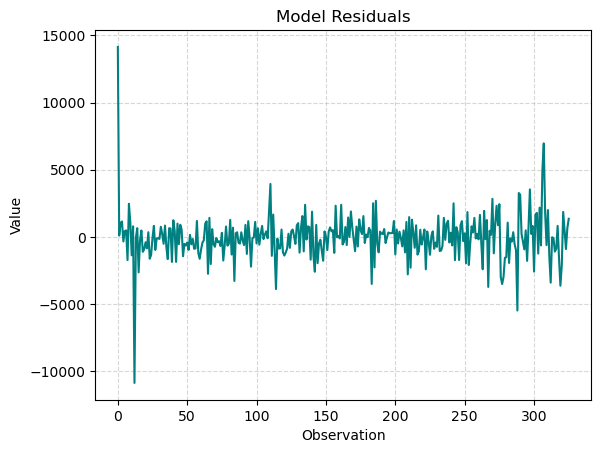

In [47]:
residuals = model_sarima.resid

# Perform the Jarque-Bera test
jb_test = sm.stats.stattools.jarque_bera(residuals)

# Print the results
print(jb_test)

plt.plot(residuals, linestyle='-', color='teal')
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Model Residuals')
plt.xlabel('Observation')
plt.ylabel('Value')

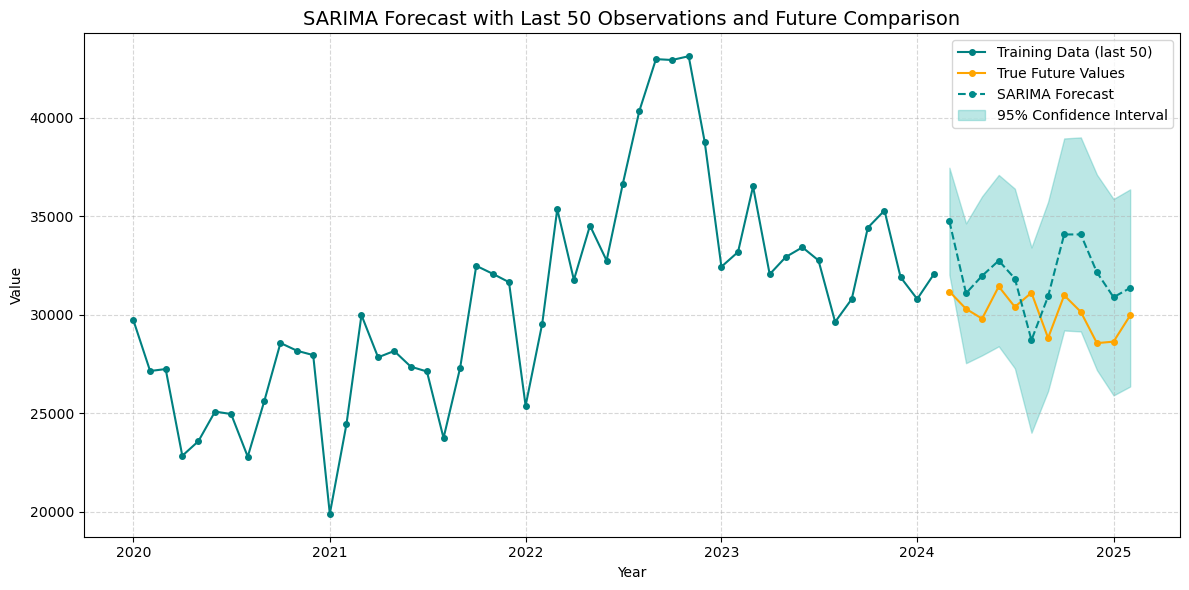

Root Mean-squared Error: 2533.201315200346


In [67]:
import matplotlib.pyplot as plt

# Extract last 50 training dates and values
X_train_last50 = X_train[-50:]
Y_train_last50 = Y_train[-50:]

# Forecast
forecast_object = model_sarima.get_forecast(steps=12)
forecast_mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(X_train_last50, Y_train_last50, color='teal',marker='o', markersize=4, label='Training Data (last 50)')
plt.plot(X_test, Y_test, 'o-', color='Orange',markersize=4, label='True Future Values')
plt.plot(X_test, forecast_mean, 'o--',markersize=4, color='darkcyan', label='SARIMA Forecast')
plt.fill_between(X_test,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='lightseagreen',
                 alpha=0.3,
                 label='95% Confidence Interval')

# Formatting
plt.title('SARIMA Forecast with Last 50 Observations and Future Comparison', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# RMSE
rmse = (np.mean((Y_test-forecast_mean)**2))**0.5
print('Root Mean-squared Error:', rmse)

## Gaussian Process Regression Approach

Gaussian Process Regression is a flexible Bayesian approach to prediction where let the function that our target variable follows remain general but impose the assumption that our uncertainty is Gaussian. 

In [50]:
X_train

0     1997-01-01
1     1997-02-01
2     1997-03-01
3     1997-04-01
4     1997-05-01
         ...    
321   2023-10-01
322   2023-11-01
323   2023-12-01
324   2024-01-01
325   2024-02-01
Name: date, Length: 326, dtype: datetime64[ns]

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

X_train_numeric = np.array(list(range(0,326))).reshape(-1, 1)
X_test_numeric = np.array(list(range(326,338))).reshape(-1, 1)

kernel = RBF(length_scale=1.0)

# Fit GPR
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)
gpr.fit(X_train_numeric, Y_train)

Y_pred, y_std = gpr.predict(X_test_numeric, return_std=True)

rmse = (np.mean((Y_pred-Y_test)**2))**0.5
print('Root Mean-squared Error:', rmse)

NameError: name 'forecast_mean' is not defined

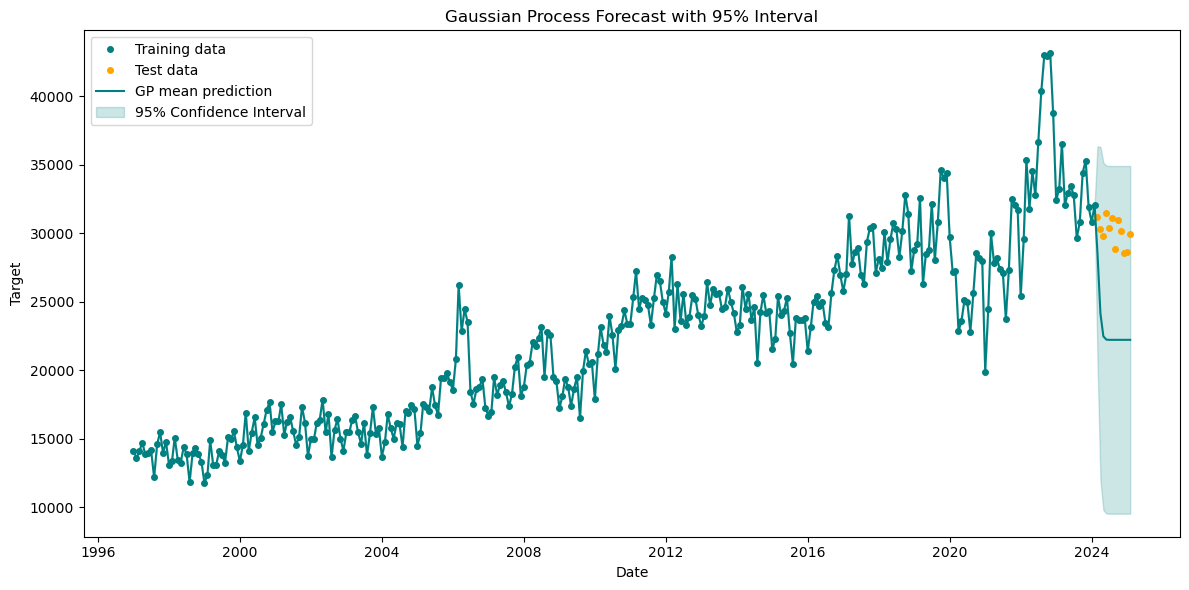

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Combine train and test for smooth prediction
X_all_numeric = np.concatenate([X_train_numeric, X_test_numeric])
X_all = np.concatenate([X_train, X_test])  # For time axis

# Predict
y_pred, y_std = gpr.predict(X_all_numeric, return_std=True)

# 95% confidence interval
y_lower = y_pred - 1.96 * y_std
y_upper = y_pred + 1.96 * y_std

# Plot
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(X_train, Y_train, 'o', label='Training data', markersize=4, color='teal')

# Plot test data
plt.plot(X_test, Y_test, 'o', label='Test data', markersize=4, color='orange')

# GP mean prediction
plt.plot(X_all, y_pred, color='teal', label='GP mean prediction')

# Confidence interval
plt.fill_between(X_all, y_lower, y_upper, color='teal', alpha=0.2, label='95% Confidence Interval')

plt.title('Gaussian Process Forecast with 95% Interval')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.tight_layout()
plt.show()


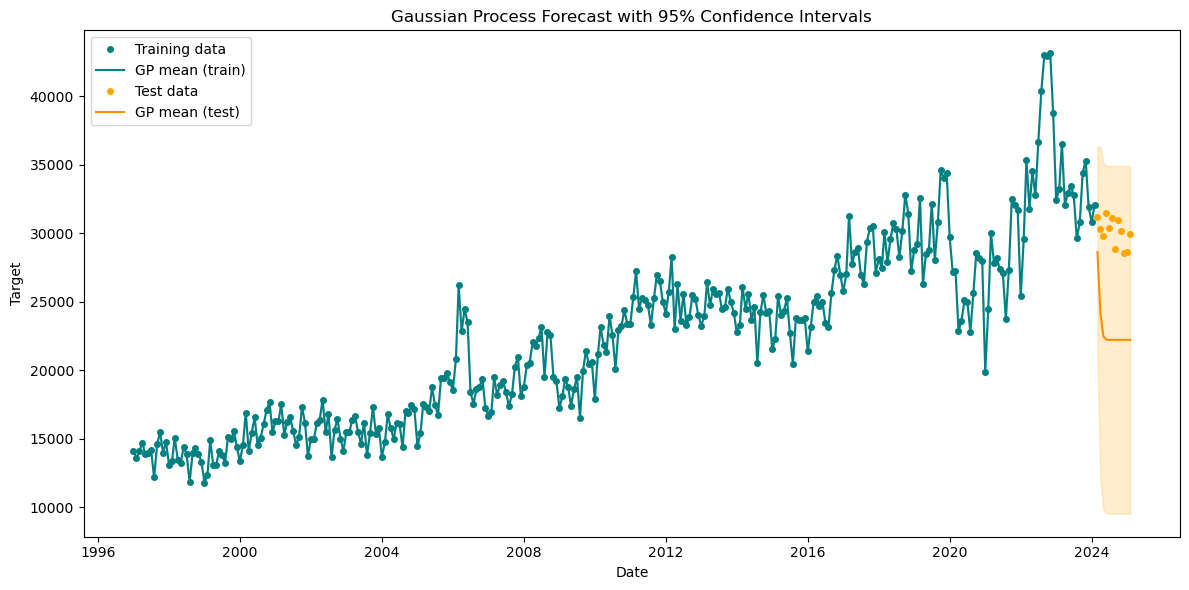

In [74]:
# Predict for training and test separately
y_pred_train, y_std_train = gpr.predict(X_train_numeric, return_std=True)
y_pred_test, y_std_test = gpr.predict(X_test_numeric, return_std=True)

# Confidence intervals
y_lower_train = y_pred_train - 1.96 * y_std_train
y_upper_train = y_pred_train + 1.96 * y_std_train
y_lower_test = y_pred_test - 1.96 * y_std_test
y_upper_test = y_pred_test + 1.96 * y_std_test

# Plot
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(X_train, Y_train, 'o', label='Training data', markersize=4, color='teal')

# GP mean prediction on training data
plt.plot(X_train, y_pred_train, '-', color='teal', label='GP mean (train)')
plt.fill_between(X_train, y_lower_train, y_upper_train, color='teal', alpha=0.2)

# Plot test data
plt.plot(X_test, Y_test, 'o', label='Test data', markersize=4, color='orange')

# GP mean prediction on test data
plt.plot(X_test, y_pred_test, '-', color='darkorange', label='GP mean (test)')
plt.fill_between(X_test, y_lower_test, y_upper_test, color='orange', alpha=0.2)

plt.title('Gaussian Process Forecast with 95% Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.tight_layout()
plt.show()



c:\Users\colle\anaconda3\envs\charlie\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\colle\anaconda3\envs\charlie\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\colle\anaconda3\envs\charlie\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\colle\

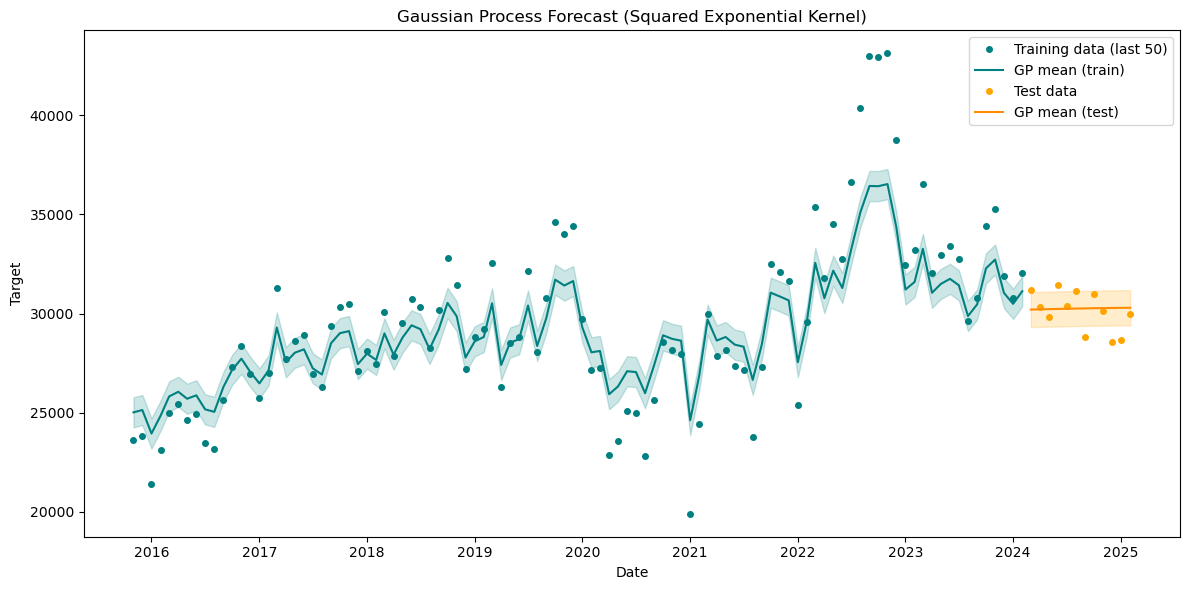

Root Mean-squared Error: 7539.773780880035


In [211]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, ExpSineSquared, RationalQuadratic, WhiteKernel
from sklearn.gaussian_process.kernels import DotProduct


from sklearn.preprocessing import StandardScaler

# Rescale time
scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric)
X_test_numeric_scaled = scaler.transform(X_test_numeric)

kernel = (
    ConstantKernel() * RBF() +  # Global trend
    ConstantKernel() * ExpSineSquared() +  # Periodic patterns
    WhiteKernel()  # Noise
)

gpr = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.1,
    n_restarts_optimizer=20,
    normalize_y=False  # Often better for time series
)
# Fit GP with hyperparameter optimization
#gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-2, n_restarts_optimizer=100, normalize_y=True)
gpr.fit(X_train_numeric_scaled, Y_train)

# Select last 50 training points
n_last = 100
X_train_last = X_train[-n_last:]
Y_train_last = Y_train[-n_last:]
X_train_numeric_scaled_last = X_train_numeric_scaled[-n_last:]

# Predict
y_pred_train, y_std_train = gpr.predict(X_train_numeric_scaled_last, return_std=True)
y_pred_test, y_std_test = gpr.predict(X_test_numeric_scaled, return_std=True)

# Confidence intervals
y_lower_train = y_pred_train - 1.96 * y_std_train
y_upper_train = y_pred_train + 1.96 * y_std_train
y_lower_test = y_pred_test - 1.96 * y_std_test
y_upper_test = y_pred_test + 1.96 * y_std_test

# Plot
plt.figure(figsize=(12, 6))
plt.plot(X_train_last, Y_train_last, 'o', label='Training data (last 50)', markersize=4, color='teal')
plt.fill_between(X_train_last, y_lower_train, y_upper_train, color='teal', alpha=0.2)
plt.plot(X_train_last, y_pred_train, '-', color='teal', label='GP mean (train)')

plt.plot(X_test, Y_test, 'o', label='Test data', markersize=4, color='orange')
plt.plot(X_test, y_pred_test, '-', color='darkorange', label='GP mean (test)')
plt.fill_between(X_test, y_lower_test, y_upper_test, color='orange', alpha=0.2)

plt.title('Gaussian Process Forecast (Squared Exponential Kernel)')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.tight_layout()
plt.show()

rmse = (np.mean((Y_pred-y_pred_test)**2))**0.5
print('Root Mean-squared Error:', rmse)

In [102]:
# After fitting the model
print("Optimized kernel:", gpr.kernel_)


Optimized kernel: 2.42**2 * RBF(length_scale=0.1) + DotProduct(sigma_0=1e-05)


The simplistic kernel cannot describe the seasonality and long term trend and just reverts to the sample mean in the predictions. We can see this as the length parameter is so small that just a few predictions in, the covariance between these points and the end of the training sample is so small that the predictions dive towards the sample mean.

Next we will try a more complex kernel:

In [ ]:


from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel, ConstantKernel

# Trend kernel: Increase the variance and allow broader trends
trend_kernel = ConstantKernel(1.0, constant_value_bounds=(0.05, 10.0)) * RBF(length_scale=50.0, length_scale_bounds=(20.0, 100.0))

# Seasonal kernel: Increase flexibility with a wider length_scale and periodicity bounds
seasonal_kernel = ConstantKernel(1.0, constant_value_bounds=(0.1, 10.0)) \
                  * ExpSineSquared(length_scale=1.0, 
                                   periodicity=7.0, 
                                   length_scale_bounds=(0.1, 10.0),
                                   periodicity_bounds=(5.0, 9.0))

# Medium-term kernel to capture more variation
medium_kernel = ConstantKernel(0.5, constant_value_bounds=(0.01, 5.0)) * RBF(length_scale=3.0, length_scale_bounds=(1.0, 10.0))

# Noise kernel (small amount of noise)
noise_kernel = WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 1.0))

# Combine all kernels
kernel = trend_kernel + seasonal_kernel + medium_kernel + noise_kernel


c:\Users\colle\anaconda3\envs\charlie\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\colle\anaconda3\envs\charlie\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__length_scale is close to the specified lower bound 20.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\colle\anaconda3\envs\charlie\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\colle\

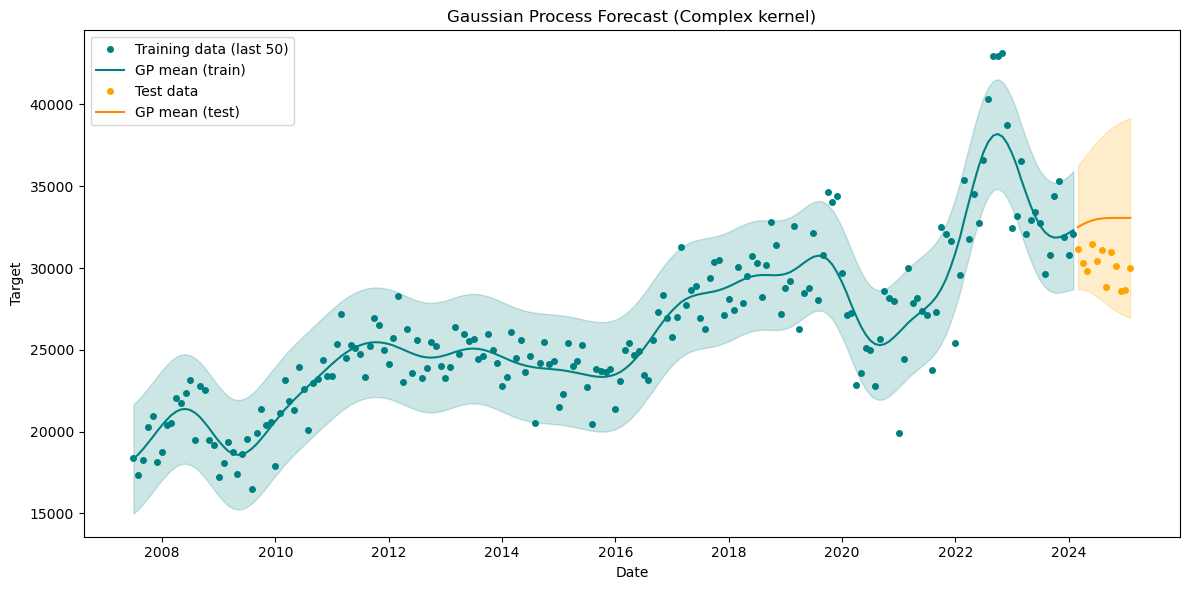

Root Mean-squared Error: 10192.882414883063


In [208]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, ExpSineSquared, RationalQuadratic, WhiteKernel
from sklearn.gaussian_process.kernels import DotProduct


from sklearn.preprocessing import StandardScaler

# Rescale time
scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric)
X_test_numeric_scaled = scaler.transform(X_test_numeric)

# Fit GP with hyperparameter optimization
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-2, n_restarts_optimizer=10, normalize_y=True)
gpr.fit(X_train_numeric_scaled, Y_train)

# Select last 50 training points
n_last = 200
X_train_last = X_train[-n_last:]
Y_train_last = Y_train[-n_last:]
X_train_numeric_scaled_last = X_train_numeric_scaled[-n_last:]

# Predict
y_pred_train, y_std_train = gpr.predict(X_train_numeric_scaled_last, return_std=True)
y_pred_test, y_std_test = gpr.predict(X_test_numeric_scaled, return_std=True)

# Confidence intervals
y_lower_train = y_pred_train - 1.96 * y_std_train
y_upper_train = y_pred_train + 1.96 * y_std_train
y_lower_test = y_pred_test - 1.96 * y_std_test
y_upper_test = y_pred_test + 1.96 * y_std_test

# Plot
plt.figure(figsize=(12, 6))
plt.plot(X_train_last, Y_train_last, 'o', label='Training data (last 50)', markersize=4, color='teal')
plt.fill_between(X_train_last, y_lower_train, y_upper_train, color='teal', alpha=0.2)
plt.plot(X_train_last, y_pred_train, '-', color='teal', label='GP mean (train)')

plt.plot(X_test, Y_test, 'o', label='Test data', markersize=4, color='orange')
plt.plot(X_test, y_pred_test, '-', color='darkorange', label='GP mean (test)')
plt.fill_between(X_test, y_lower_test, y_upper_test, color='orange', alpha=0.2)

plt.title('Gaussian Process Forecast (Complex kernel)')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.tight_layout()
plt.show()

rmse = (np.mean((Y_pred-y_pred_test)**2))**0.5
print('Root Mean-squared Error:', rmse)

In [209]:
# After fitting the model
print("Optimized kernel:", gpr.kernel_)

Optimized kernel: 0.224**2 * RBF(length_scale=20) + 0.369**2 * ExpSineSquared(length_scale=0.1, periodicity=5) + 1.9**2 * RBF(length_scale=3.08) + WhiteKernel(noise_level=0.0617)


In [8]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel, ConstantKernel as C
from itertools import combinations, product
import warnings

# Suppress convergence warnings during fitting
warnings.filterwarnings("ignore", category=UserWarning)

# Define base kernels
base_kernels = [
    C(1.0) * RBF(length_scale=10.0),
    C(1.0) * ExpSineSquared(length_scale=1.0, periodicity=12.0),
    C(1.0) * RationalQuadratic(length_scale=1.0, alpha=1.0),
    WhiteKernel(noise_level=0.1)
]

# Generate combinations of kernels
def generate_kernel_combinations(base_kernels, max_depth=2):
    kernel_combinations = []
    for r in range(1, max_depth + 1):
        for combo in combinations(base_kernels, r):
            # Try both additive and multiplicative compositions
            for ops in product(['+', '*'], repeat=r - 1):
                kernel = combo[0]
                for op, k in zip(ops, combo[1:]):
                    kernel = kernel + k if op == '+' else kernel * k
                kernel_combinations.append(kernel)
    return kernel_combinations

# Fit GP and compute BIC
def fit_and_score_kernel(kernel, X, y):
    try:
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True, n_restarts_optimizer=5)
        gpr.fit(X, y)
        n_params = gpr.kernel_.n_dims
        n_samples = len(y)
        log_likelihood = gpr.log_marginal_likelihood()
        bic = n_params * np.log(n_samples) - 2 * log_likelihood
        return gpr, gpr.kernel_, bic
    except Exception:
        return None, None, np.inf

# Main search function
def search_best_gp_model(X, y, max_depth=2):
    X = np.array(X).reshape(-1, 1)
    kernel_list = generate_kernel_combinations(base_kernels, max_depth=max_depth)
    best_model, best_kernel, best_bic = None, None, np.inf

    for kernel in kernel_list:
        model, trained_kernel, bic = fit_and_score_kernel(kernel, X, y)
        if bic < best_bic:
            best_model = model
            best_kernel = trained_kernel
            best_bic = bic

    return best_model, best_kernel, best_bic


In [11]:
# Assuming you have X_train_numeric and Y_train
best_model, best_kernel, best_bic = search_best_gp_model(X_train_numeric, Y_train, max_depth=2)
print("Best kernel:", best_kernel)
print("BIC:", best_bic)


Best kernel: 1.82**2 * RBF(length_scale=276) + 0.528**2 * RationalQuadratic(alpha=0.11, length_scale=0.933)
BIC: 168.9918284970913


In [36]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, 
                                              ExpSineSquared, DotProduct, 
                                              ConstantKernel, WhiteKernel)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def gp_bic(gp, X, y):
    """
    Calculate Bayesian Information Criterion (BIC) for Gaussian Process.
    
    Parameters:
    gp : GaussianProcessRegressor
        Fitted Gaussian Process model
    X : array-like
        Input features
    y : array-like
        Target values
        
    Returns:
    float : BIC value
    """
    n = X.shape[0]  # number of samples
    mll = gp.log_marginal_likelihood()  # marginal log likelihood
    k = len(gp.kernel_.theta)  # number of kernel parameters
    bic = -2 * mll + k * np.log(n)
    return bic

def search_best_gp_kernel(X, y, test_size=0.2, random_state=None):
    """
    Search through kernel space to find best Gaussian Process model by BIC.
    
    Parameters:
    X : array-like
        Input features
    y : array-like
        Target values
    test_size : float
        Proportion of data to use for validation
    random_state : int
        Random seed for reproducibility
        
    Returns:
    dict : Information about the best model found
    """
    
    
    # Define a variety of kernels to search through
    kernels = [
        # Simple kernels
        ConstantKernel() * RBF() + WhiteKernel(),
        ConstantKernel() * Matern(nu=1.5) + WhiteKernel(),
        ConstantKernel() * Matern(nu=2.5) + WhiteKernel(),
        ConstantKernel() * RationalQuadratic() + WhiteKernel(),
        
        # Periodic kernels (useful for time series)
        ConstantKernel() * ExpSineSquared(periodicity=12) + WhiteKernel(),
        ConstantKernel() * RBF() * ExpSineSquared(periodicity=12) + WhiteKernel(),
        
        # Linear + RBF
        ConstantKernel() * (DotProduct() + RBF()) + WhiteKernel(),
        
        # More complex combinations
        ConstantKernel() * (RBF() + Matern(nu=1.5)) + WhiteKernel(),
        ConstantKernel() * (RBF() * Matern(nu=1.5)) + WhiteKernel(),
    ]
    
    best_bic = np.inf
    best_model = None
    best_kernel = None
    results = []
    
    for kernel in kernels:
        try:
            gp = GaussianProcessRegressor(
                kernel=kernel,
                alpha=1e-5,  # can be tuned
                n_restarts_optimizer=10,
                random_state=random_state
            )
            
            # Fit the model
            gp.fit(X_train_numeric, Y_train)
            
            # Calculate BIC on training data
            current_bic = gp_bic(gp, X_train_numeric, Y_train)
            
            # Calculate RMSE on validation set
            y_pred, y_std = gp.predict(X_test_numeric, return_std=True)
            rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
            
            # Store results
            result = {
                'kernel': str(kernel),
                'bic': current_bic,
                'rmse': rmse,
                'model': gp,
                'kernel_params': gp.kernel_
            }
            results.append(result)
            
            # Update best model if current is better
            if current_bic < best_bic:
                best_bic = current_bic
                best_model = gp
                best_kernel = kernel
                best_result = result
                
            print(f"Kernel: {kernel}")
            print(f"BIC: {current_bic:.2f}, RMSE: {rmse:.4f}")
            print("-" * 50)
            
        except Exception as e:
            print(f"Failed with kernel {kernel}. Error: {str(e)}")
            continue
    
    # Sort results by BIC
    results_sorted = sorted(results, key=lambda x: x['bic'])
    
    print("\n=== Best Model ===")
    print(f"Kernel: {best_kernel}")
    print(f"BIC: {best_bic:.2f}")
    print(f"Validation RMSE: {best_result['rmse']:.4f}")
    print(f"Kernel parameters: {best_model.kernel_}")
    
    return {
        'best_model': best_model,
        'best_kernel': best_kernel,
        'best_bic': best_bic,
        'best_rmse': best_result['rmse'],
        'all_results': results_sorted
    }

search_best_gp_kernel(X_train_numeric, Y_train)

Kernel: 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1)
BIC: 37817.05, RMSE: 1491.3008
--------------------------------------------------
Kernel: 1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)
BIC: 36658.58, RMSE: 1743.2931
--------------------------------------------------
Kernel: 1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1)
BIC: 37212.08, RMSE: 1603.8327
--------------------------------------------------
Kernel: 1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)
BIC: 30467.84, RMSE: 1746.6544
--------------------------------------------------
Kernel: 1**2 * ExpSineSquared(length_scale=1, periodicity=12) + WhiteKernel(noise_level=1)
BIC: 37817.33, RMSE: 1491.7171
--------------------------------------------------
Kernel: 1**2 * RBF(length_scale=1) * ExpSineSquared(length_scale=1, periodicity=12) + WhiteKernel(noise_level=1)
BIC: 37828.56, RMSE: 1491.3081
--------------------------------------------------
Ker

{'best_model': GaussianProcessRegressor(alpha=1e-05,
                          kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1),
                          n_restarts_optimizer=10),
 'best_kernel': 1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1),
 'best_bic': 15822.386126982332,
 'best_rmse': 2942.1097565143136,
 'all_results': [{'kernel': '1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1)',
   'bic': 15822.386126982332,
   'rmse': 2942.1097565143136,
   'model': GaussianProcessRegressor(alpha=1e-05,
                            kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1),
                            n_restarts_optimizer=10),
   'kernel_params': 316**2 * DotProduct(sigma_0=37.9) + RBF(length_scale=1e-05) + WhiteKernel(noise_level=1e+05)},
  {'kernel': '1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)',
   'b

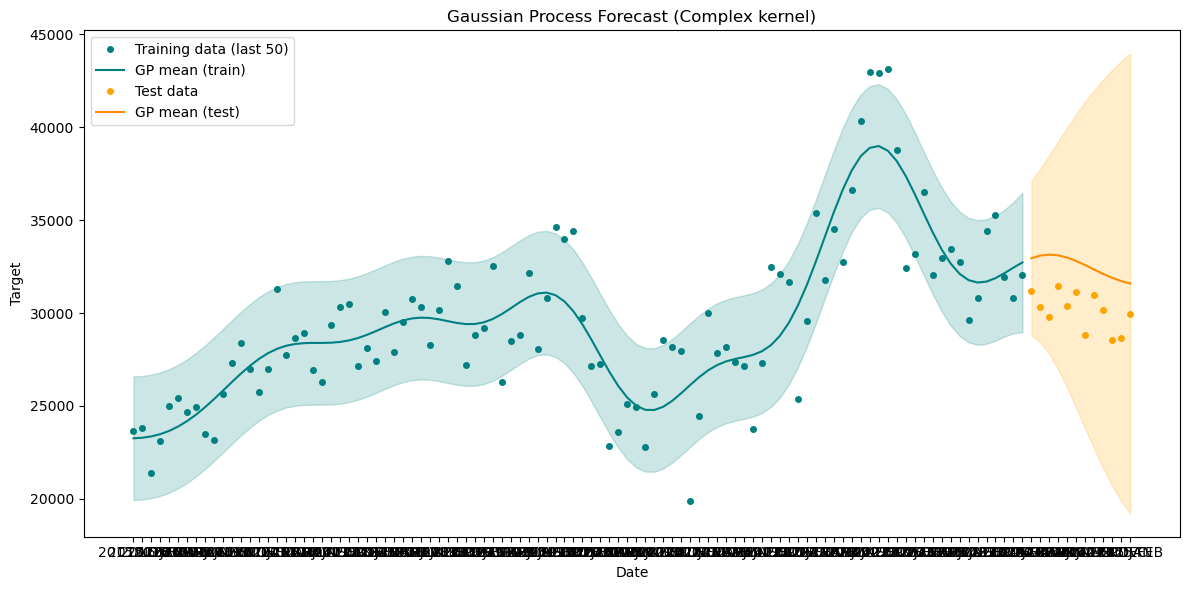

Evidence: -103.40209927322661
Root Mean-squared Error: 9738.401051431885
Optimized kernel: 0.00841**2 * DotProduct(sigma_0=159) + RBF(length_scale=8.51) + WhiteKernel(noise_level=0.0599)


In [ ]:
kernel = 1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1)

# Fit GP with hyperparameter optimization
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-2, n_restarts_optimizer=10, normalize_y=True)
gpr.fit(X_train_numeric, Y_train)

# Select last 50 training points
n_last = 100
X_train_last = X_train[-n_last:]
Y_train_last = Y_train[-n_last:]
X_train_numeric_scaled_last = X_train_numeric[-n_last:]

# Predict
y_pred_train, y_std_train = gpr.predict(X_train_numeric_scaled_last, return_std=True)
y_pred_test, y_std_test = gpr.predict(X_test_numeric, return_std=True)

# Confidence intervals
y_lower_train = y_pred_train - 1.96 * y_std_train
y_upper_train = y_pred_train + 1.96 * y_std_train
y_lower_test = y_pred_test - 1.96 * y_std_test
y_upper_test = y_pred_test + 1.96 * y_std_test

# Plot
plt.figure(figsize=(12, 6))
plt.plot(X_train_last, Y_train_last, 'o', label='Training data (last 50)', markersize=4, color='teal')
plt.fill_between(X_train_last, y_lower_train, y_upper_train, color='teal', alpha=0.2)
plt.plot(X_train_last, y_pred_train, '-', color='teal', label='GP mean (train)')

plt.plot(X_test, Y_test, 'o', label='Test data', markersize=4, color='orange')
plt.plot(X_test, y_pred_test, '-', color='darkorange', label='GP mean (test)')
plt.fill_between(X_test, y_lower_test, y_upper_test, color='orange', alpha=0.2)

plt.title('Gaussian Process Forecast (Complex kernel)')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.tight_layout()
plt.show()

loglik= gpr.log_marginal_likelihood_value_
print('Evidence:', loglik)
rmse = np.sqrt(mean_squared_error(Y_test, y_pred_test))
print('Root Mean-squared Error:', rmse)
# After fitting the model
print("Optimized kernel:", gpr.kernel_)

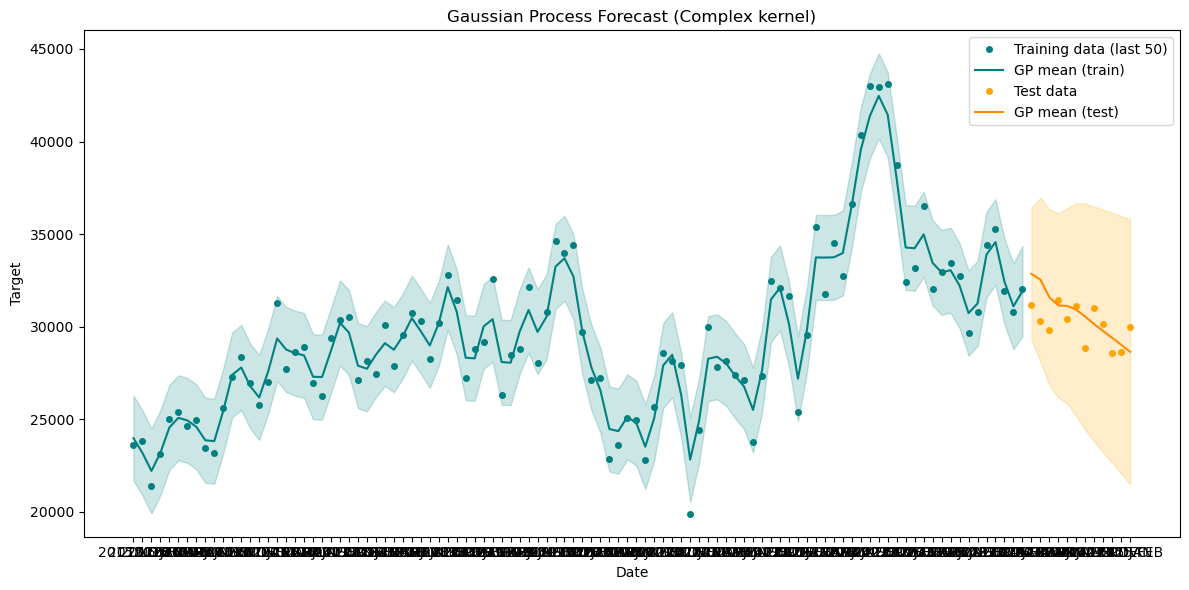

Evidence: -70.14221539349114
Root Mean-squared Error: 7824.691795769334
Optimized kernel: 0.863**2 * RBF(length_scale=25) + 0.32**2 * RBF(length_scale=3.62) * ExpSineSquared(length_scale=1.62, periodicity=5.28) + 0.367**2 * WhiteKernel(noise_level=0.135)


In [ ]:
kernel = (1**2 * RBF(length_scale=15, length_scale_bounds= (3,25)) # Long term trend
          + 1**2 * RBF(length_scale=1) * ExpSineSquared(length_scale=1, periodicity=12, periodicity_bounds=(4,8)) # Periodic Part
          + 1**2 * WhiteKernel(noise_level=1) # Noise Part
        )

# Fit GP with hyperparameter optimization
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-2, n_restarts_optimizer=10, normalize_y=True)
gpr.fit(X_train_numeric, Y_train)

# Select last 50 training points
n_last = 100
X_train_last = X_train[-n_last:]
Y_train_last = Y_train[-n_last:]
X_train_numeric_scaled_last = X_train_numeric[-n_last:]

# Predict
y_pred_train, y_std_train = gpr.predict(X_train_numeric_scaled_last, return_std=True)
y_pred_test, y_std_test = gpr.predict(X_test_numeric, return_std=True)

# Confidence intervals
y_lower_train = y_pred_train - 1.96 * y_std_train
y_upper_train = y_pred_train + 1.96 * y_std_train
y_lower_test = y_pred_test - 1.96 * y_std_test
y_upper_test = y_pred_test + 1.96 * y_std_test

# Plot
plt.figure(figsize=(12, 6))
plt.plot(X_train_last, Y_train_last, 'o', label='Training data (last 50)', markersize=4, color='teal')
plt.fill_between(X_train_last, y_lower_train, y_upper_train, color='teal', alpha=0.2)
plt.plot(X_train_last, y_pred_train, '-', color='teal', label='GP mean (train)')

plt.plot(X_test, Y_test, 'o', label='Test data', markersize=4, color='orange')
plt.plot(X_test, y_pred_test, '-', color='darkorange', label='GP mean (test)')
plt.fill_between(X_test, y_lower_test, y_upper_test, color='orange', alpha=0.2)

plt.title('Gaussian Process Forecast (Complex kernel)')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.tight_layout()
plt.show()

loglik= gpr.log_marginal_likelihood_value_
print('Evidence:', loglik)
rmse = (np.mean((Y_pred-y_pred_test)**2))**0.5
print('Root Mean-squared Error:', rmse)
# After fitting the model
print("Optimized kernel:", gpr.kernel_)

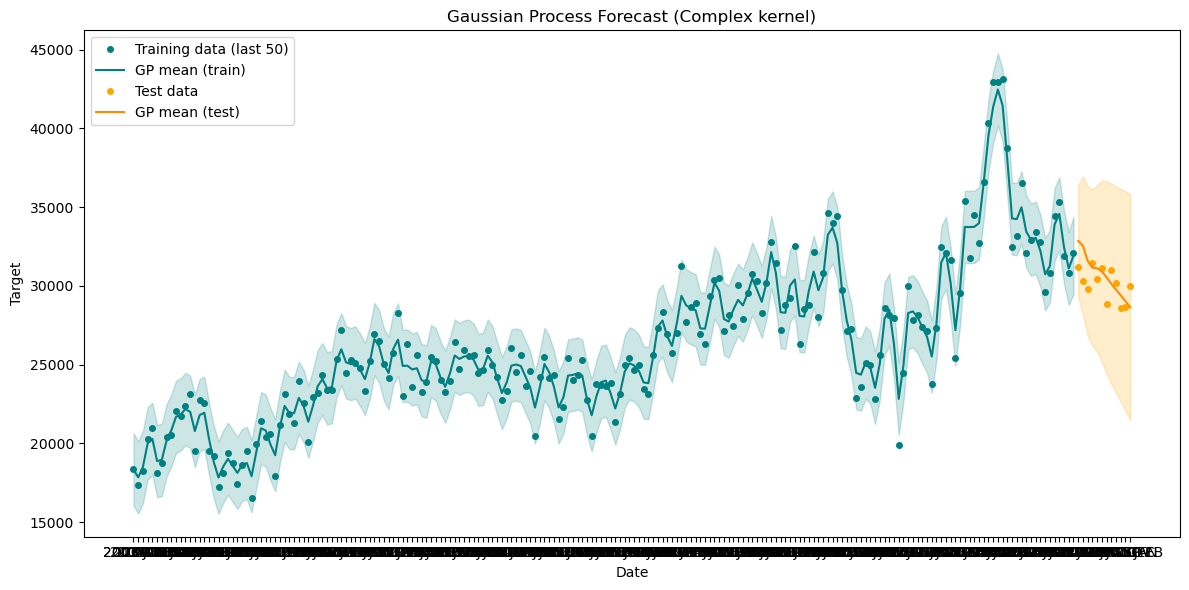

Root Mean-squared Error: 7824.691795769334
Evidence: -70.14221539349114
Root Mean-squared Error: 7824.691795769334
Optimized kernel: 0.863**2 * RBF(length_scale=25) + 0.32**2 * RBF(length_scale=3.62) * ExpSineSquared(length_scale=1.62, periodicity=5.28) + 0.367**2 * WhiteKernel(noise_level=0.135)


In [39]:
kernel = (1**2 * RBF(length_scale=15, length_scale_bounds= (3,25)) # Long term trend
          + 1**2 * RBF(length_scale=1) * ExpSineSquared(length_scale=1, periodicity=12, periodicity_bounds=(4,8)) # Periodic Part
          + 1**2 * WhiteKernel(noise_level=1) # Noise Part
        )

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, ExpSineSquared, RationalQuadratic, WhiteKernel
from sklearn.gaussian_process.kernels import DotProduct


from sklearn.preprocessing import StandardScaler

# Rescale time
scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric)
X_test_numeric_scaled = scaler.transform(X_test_numeric)

# Fit GP with hyperparameter optimization
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-2, n_restarts_optimizer=10, normalize_y=True)
gpr.fit(X_train_numeric, Y_train)

# Select last 50 training points
n_last = 200
X_train_last = X_train[-n_last:]
Y_train_last = Y_train[-n_last:]
X_train_numeric_scaled_last = X_train_numeric[-n_last:]

# Predict
y_pred_train, y_std_train = gpr.predict(X_train_numeric_scaled_last, return_std=True)
y_pred_test, y_std_test = gpr.predict(X_test_numeric, return_std=True)

# Confidence intervals
y_lower_train = y_pred_train - 1.96 * y_std_train
y_upper_train = y_pred_train + 1.96 * y_std_train
y_lower_test = y_pred_test - 1.96 * y_std_test
y_upper_test = y_pred_test + 1.96 * y_std_test

# Plot
plt.figure(figsize=(12, 6))
plt.plot(X_train_last, Y_train_last, 'o', label='Training data (last 50)', markersize=4, color='teal')
plt.fill_between(X_train_last, y_lower_train, y_upper_train, color='teal', alpha=0.2)
plt.plot(X_train_last, y_pred_train, '-', color='teal', label='GP mean (train)')

plt.plot(X_test, Y_test, 'o', label='Test data', markersize=4, color='orange')
plt.plot(X_test, y_pred_test, '-', color='darkorange', label='GP mean (test)')
plt.fill_between(X_test, y_lower_test, y_upper_test, color='orange', alpha=0.2)

plt.title('Gaussian Process Forecast (Complex kernel)')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.tight_layout()
plt.show()

rmse = (np.mean((Y_pred-y_pred_test)**2))**0.5
print('Root Mean-squared Error:', rmse)

loglik= gpr.log_marginal_likelihood_value_
print('Evidence:', loglik)
rmse = (np.mean((Y_pred-y_pred_test)**2))**0.5
print('Root Mean-squared Error:', rmse)
# After fitting the model
print("Optimized kernel:", gpr.kernel_)